## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [10]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

### Data Load

In [11]:
# 데이터 로드
Total_train = pd.read_csv('../data/Total_train_dataset_43.csv')
Total_test = pd.read_csv('../data/Total_test_dataset_43.csv')

In [12]:
# ID 열을 제외한 특성과 타겟 변수 분리
Total_X = Total_train.drop(['임신_성공_여부', 'ID'], axis=1)
Total_y = Total_train['임신_성공_여부']

### 인코딩 

In [13]:
Total_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256344 entries, 0 to 256343
Data columns (total 94 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   시술_당시_나이               256344 non-null  object 
 1   임신_시도_또는_마지막_임신_경과_연수  256344 non-null  float64
 2   배란_자극_여부               256344 non-null  int64  
 3   단일_배아_이식_여부            256344 non-null  float64
 4   착상_전_유전_검사_사용_여부       256344 non-null  float64
 5   착상_전_유전_진단_사용_여부       256344 non-null  float64
 6   남성_주_불임_원인             256344 non-null  int64  
 7   남성_부_불임_원인             256344 non-null  int64  
 8   여성_주_불임_원인             256344 non-null  int64  
 9   여성_부_불임_원인             256344 non-null  int64  
 10  부부_주_불임_원인             256344 non-null  int64  
 11  부부_부_불임_원인             256344 non-null  int64  
 12  불명확_불임_원인              256344 non-null  int64  
 13  불임_원인_-_난관_질환          256344 non-null  int64  
 14  불임_원인_-_남성_요인          256344 non-nu

In [14]:
Total_categorical_columns = [
    "시술_당시_나이",
    "난자_기증자_나이",
    "정자_기증자_나이"
]

In [15]:
# 모든 범주형 변수를 문자열로 변환
Total_X[Total_categorical_columns] = Total_X[Total_categorical_columns].astype(str)
Total_test[Total_categorical_columns] = Total_test[Total_categorical_columns].astype(str)

# OrdinalEncoder를 사용하여 범주형 변수 인코딩
Total_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

Total_X[Total_categorical_columns] = Total_encoder.fit_transform(Total_X[Total_categorical_columns])
Total_test[Total_categorical_columns] = Total_encoder.transform(Total_test[Total_categorical_columns])

## Modeling

In [16]:
# 데이터 분할
Total_X_train, Total_X_test, Total_y_train, Total_y_test = train_test_split(Total_X, 
                                                                            Total_y, 
                                                                            test_size=0.2, 
                                                                            random_state=42,
                                                                            stratify=Total_y)

### Total 데이터


--- Model Performance ---
Model Accuracy: 0.7444264565331877
Model F1 Score: 0.2317209029610085
Model AUC: 0.7381679564681765


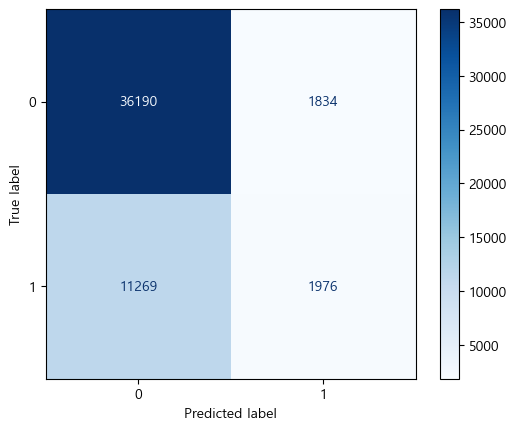

In [17]:
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# LightGBM 모델 초기화 및 학습
lgb_model = lgb.LGBMClassifier(
    n_estimators=7655,
    num_leaves=2855,
    max_depth=5,
    learning_rate=0.16281911161693016,
    min_child_samples=460,
    subsample=0.38886888090131794,
    reg_alpha=36.93967560025368,
    reg_lambda=96.03211423886586,
    metric='auc',
    objective='binary',
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)
lgb_model.fit(Total_X_train, Total_y_train)
lgb_pred_proba = lgb_model.predict_proba(Total_X_test)[:, 1]

# XGBoost 모델 초기화 및 학습
xgb_model = xgb.XGBClassifier(
    n_estimators=6377,
    learning_rate=0.09743491488399733,
    max_depth=414,
    alpha=2.5680787908055764,
    gamma=1.6904727699858604,
    reg_alpha=33.97190639119776,
    reg_lambda=93.11438571710458,
    subsample=0.7198107387781483,
    objective='binary:logistic',
    tree_method='hist',
    eval_metric='auc',
    random_state=42,
    verbosity=0
)
xgb_model.fit(Total_X_train, Total_y_train)
xgb_pred_proba = xgb_model.predict_proba(Total_X_test)[:, 1]

# CatBoost 모델 초기화 및 학습
cat_model = CatBoostClassifier(
    iterations=3642,  
    learning_rate=0.011319255101779519,  
    min_data_in_leaf=10,  
    l2_leaf_reg=0.26672586343839627, 
    random_strength=7.807598915814621,  
    bagging_temperature=98.98267794711023,  
    border_count=46,  
    eval_metric='AUC',
    random_seed=42,
    boosting_type='Plain',
    logging_level='Silent'
)
cat_model.fit(Total_X_train, Total_y_train)
cat_pred_proba = cat_model.predict_proba(Total_X_test)[:, 1]

# 세 모델의 예측 확률을 결합하여 최종 예측 확률 결정
final_pred_proba = []
for lgb_prob, xgb_prob, cat_prob in zip(lgb_pred_proba, xgb_pred_proba, cat_pred_proba):
    probs = [lgb_prob, xgb_prob, cat_prob]
    if sum(prob > 0.3 for prob in probs) >= 2:
        final_pred_proba.append(max(probs))
    else:
        final_pred_proba.append(min(probs))

# 최종 예측
final_pred = np.array(final_pred_proba) > 0.5

# 평가
accuracy = accuracy_score(Total_y_test, final_pred)
f1 = f1_score(Total_y_test, final_pred)
auc = roc_auc_score(Total_y_test, final_pred_proba)
cm = confusion_matrix(Total_y_test, final_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

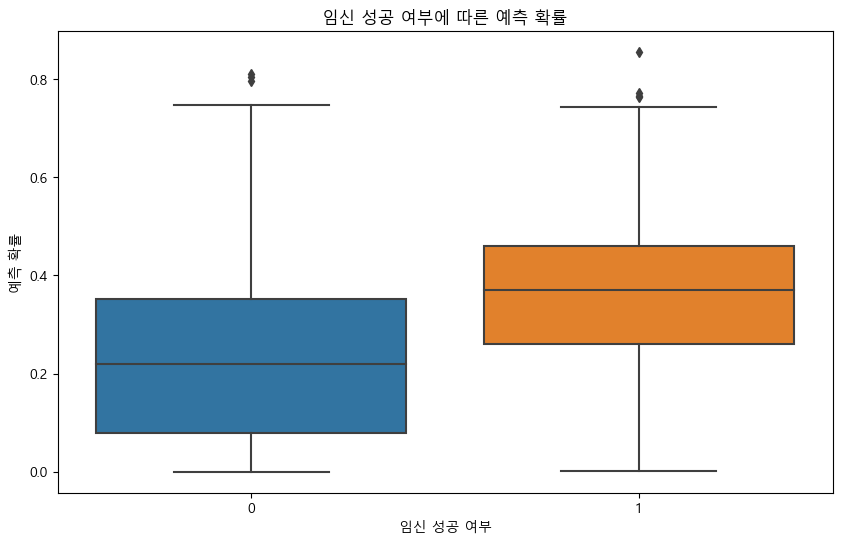

In [18]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns

# y_pred_proba를 임신_성공_여부에 따라 박스플롯으로 출력
result_df = pd.DataFrame({'임신_성공_여부': Total_y_test, '예측_확률': final_pred_proba})

# 박스플롯 출력
plt.figure(figsize=(10, 6))
sns.boxplot(x='임신_성공_여부', y='예측_확률', data=result_df)
plt.title('임신 성공 여부에 따른 예측 확률')
plt.xlabel('임신 성공 여부')
plt.ylabel('예측 확률')
plt.show()

데이콘 PUBLIC 0.7398746247

## 제출

In [20]:
# 전체 데이터로 모델 학습
lgb_model.fit(Total_X, Total_y)
xgb_model.fit(Total_X, Total_y)
cat_model.fit(Total_X, Total_y)

# 예측 확률 계산
lgb_pred_proba = lgb_model.predict_proba(Total_test.drop('ID', axis=1))[:, 1]
xgb_pred_proba = xgb_model.predict_proba(Total_test.drop('ID', axis=1))[:, 1]
cat_pred_proba = cat_model.predict_proba(Total_test.drop('ID', axis=1))[:, 1]

# 세 모델의 예측 확률을 결합하여 최종 예측 확률 결정
final_pred_proba = []
for lgb_prob, xgb_prob, cat_prob in zip(lgb_pred_proba, xgb_pred_proba, cat_pred_proba):
    probs = [lgb_prob, xgb_prob, cat_prob]
    if sum(prob > 0.3 for prob in probs) >= 2:
        final_pred_proba.append(max(probs))
    else:
        final_pred_proba.append(min(probs))

# 최종 예측 확률을 Total_test 데이터프레임에 추가
Total_test['probability'] = final_pred_proba

# 최종 제출 파일 생성
submission = Total_test[['ID', 'probability']]
submission = submission.sort_values(by='ID')

In [21]:
# 제출 파일 저장
submission.to_csv('../submission/code43_all_voting.csv', index=False, encoding='utf-8')

----

.